In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import pandas as pd
from pathlib import Path


from src.data_models.caravanify import Caravanify, CaravanifyConfig

from src.data_models.datamodule import HydroDataModule

from sklearn.pipeline import Pipeline

from src.preprocessing.grouped import GroupedTransformer
# from src.preprocessing.log_scale import LogTransformer
from src.preprocessing.standard_scale import StandardScaleTransformer

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/timeseries/csv",
    gauge_id_prefix="USA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
ids_for_training = caravan.get_all_gauge_ids()[4:6]

print(f"Total number of stations: {len(ids_for_training)}")



Total number of stations: 2


In [4]:
caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()
ts_data = ts_data[ts_data["date"].dt.year >= 1981]
static_data = caravan.get_static_attributes()

In [5]:
ts_data.head()

,gauge_id,date,dewpoint_temperature_2m_max,dewpoint_temperature_2m_mean,dewpoint_temperature_2m_min,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,snow_depth_water_equivalent_max,snow_depth_water_equivalent_mean,snow_depth_water_equivalent_min,...,volumetric_soil_water_layer_1_min,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_2_mean,volumetric_soil_water_layer_2_min,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_3_mean,volumetric_soil_water_layer_3_min,volumetric_soil_water_layer_4_max,volumetric_soil_water_layer_4_mean,volumetric_soil_water_layer_4_min
10958,USA_01047000,1981-01-01,-16.94,-22.13,-28.04,2.16,0.05,52.35,52.31,52.24,...,0.24,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27
10959,USA_01047000,1981-01-02,-8.94,-14.42,-23.61,1.77,0.10,60.63,56.32,52.40,...,0.23,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27
10960,USA_01047000,1981-01-03,-25.21,-32.70,-35.18,1.83,0.08,60.59,60.49,60.42,...,0.23,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27
10961,USA_01047000,1981-01-04,-34.46,-36.62,-38.68,0.79,0.07,60.60,60.42,60.37,...,0.23,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27
10962,USA_01047000,1981-01-05,-20.98,-25.34,-33.40,2.23,0.17,60.67,60.64,60.58,...,0.23,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27


In [6]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = [
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "streamflow",
    # "julian_day",
    "temperature_2m_mean",
    "total_precipitation_sum",
]

# Filter date from 1981 onwards

In [7]:
ts_data

,gauge_id,date,dewpoint_temperature_2m_max,dewpoint_temperature_2m_mean,dewpoint_temperature_2m_min,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,snow_depth_water_equivalent_max,snow_depth_water_equivalent_mean,snow_depth_water_equivalent_min,...,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_2_mean,volumetric_soil_water_layer_2_min,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_3_mean,volumetric_soil_water_layer_3_min,volumetric_soil_water_layer_4_max,volumetric_soil_water_layer_4_mean,volumetric_soil_water_layer_4_min,julian_day
10958,USA_01047000,1981-01-01,-16.94,-22.13,-28.04,2.16,0.05,52.35,52.31,52.24,...,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27,1
10959,USA_01047000,1981-01-02,-8.94,-14.42,-23.61,1.77,0.10,60.63,56.32,52.40,...,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27,2
10960,USA_01047000,1981-01-03,-25.21,-32.70,-35.18,1.83,0.08,60.59,60.49,60.42,...,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27,3
10961,USA_01047000,1981-01-04,-34.46,-36.62,-38.68,0.79,0.07,60.60,60.42,60.37,...,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27,4
10962,USA_01047000,1981-01-05,-20.98,-25.34,-33.40,2.23,0.17,60.67,60.64,60.58,...,0.23,0.23,0.23,0.25,0.25,0.25,0.27,0.27,0.27,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53319,USA_01052500,2023-12-26,2.57,0.88,-1.05,0.35,0.15,36.57,34.88,32.58,...,0.26,0.26,0.25,0.30,0.30,0.30,0.30,0.30,0.30,360
53320,USA_01052500,2023-12-27,2.01,1.31,0.81,0.03,0.14,32.51,30.54,28.23,...,0.29,0.28,0.26,0.30,0.29,0.29,0.30,0.30,0.30,361
53321,USA_01052500,2023-12-28,2.60,1.24,0.66,0.28,0.22,28.10,25.70,23.11,...,0.32,0.30,0.29,0.30,0.29,0.29,0.30,0.30,0.30,362
53322,USA_01052500,2023-12-29,1.00,0.54,-0.02,0.14,0.08,22.98,22.42,21.94,...,0.32,0.32,0.32,0.30,0.30,0.30,0.30,0.30,0.30,363


In [8]:
whole_data = ts_columns + ["gauge_id", "date"]
ts_data = ts_data[whole_data]

# # Group by gauge_id
# grouped = ts_data.groupby("gauge_id")

# # Plot time series for each gauge of the ts_columns of the last 5 years
# for gauge_id, group in grouped:
#     group = group.set_index("date")
#     group = group.loc["2015-01-01":"2020-12-31"]
#     group[ts_columns].plot(subplots=True, figsize=(20, 20), title=gauge_id)
#     plt.show()

In [9]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,slp_dg_sav,cly_pc_sav,ele_mt_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,USA_01047000,902.895076,67.159417,8.040634,378.958111,3.694839,0.501584,0.299063,1.10043,0.052498,3.275610
1,USA_01052500,395.444910,88.993129,8.000000,644.379447,3.128363,0.462018,0.368406,1.07804,0.040657,3.402069


In [10]:
features = [
    col for col in ts_data.columns if col not in ["gauge_id", "date", "streamflow"]
]
ts_columns = features + ["streamflow"]  # Ensure target is not in features

# 1. Load and prepare CAMELS-CH data

In [11]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [12]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [13]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [14]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area",
#     "elev_mean",
#     "slope_mean",
#     "aridity",
#     "p_seasonality",
#     "frac_snow",
#     "porosity",
#     "conductivity",
#     "p_mean",
#     "geo_porosity",
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [15]:
dynamic_feature_cols = features
static_feature_cols = [c for c in static_columns if c != "gauge_id"]
target_cols = ["streamflow"]

# Feature pipeline: log + scale
feature_pipeline = Pipeline(
    [
        # ("log", LogTransformer(columns=dynamic_feature_cols)),
        ("scaler", StandardScaleTransformer(columns=dynamic_feature_cols))
    ]
)

# Target pipeline: grouped by basin with log + scale
target_pipeline = GroupedTransformer(
    Pipeline(
        [
            # ("log", LogTransformer(columns=target_cols)),
            ("scaler", StandardScaleTransformer(columns=target_cols))
        ]
    ),
    columns=target_cols,
    group_identifier="gauge_id",
    n_jobs=-1,
)

# Static feature pipeline: just scaling
static_pipeline = Pipeline(
    [("scaler", StandardScaleTransformer(columns=static_feature_cols))]
)

# Define preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline, "columns": dynamic_feature_cols},
    "target": {"pipeline": target_pipeline, "columns": target_cols},
    "static_features": {"pipeline": static_pipeline, "columns": static_feature_cols},
}

In [16]:
static_columns

['gauge_id',
 'area',
 'slp_dg_sav',
 'cly_pc_sav',
 'ele_mt_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

# 3. Create DataModule

In [17]:
output_length = 10
input_length = 40

static_columns = [c for c in static_columns if c not in ["gauge_id"]]

print("TS columns:", ts_columns)
print("Static columns:", static_columns)


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    # static_df=None,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=128,
    input_length=input_length,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    # static_features=None,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=1,
    max_missing_pct=20,
    domain_id="CL",
)

data_module.prepare_data()
data_module.setup()
# train_loader = data_module.test_dataloader()

# for i, batch in enumerate(train_loader):
#     if i >= 6:  # Look at first 6 batches
#         break

#     print(f"Slice indeces: {batch['slice_idx']}")

TS columns: ['potential_evaporation_sum_ERA5_LAND', 'potential_evaporation_sum_FAO_PENMAN_MONTEITH', 'temperature_2m_mean', 'total_precipitation_sum', 'streamflow']
Static columns: ['area', 'slp_dg_sav', 'cly_pc_sav', 'ele_mt_sav', 'aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', 'p_mean']
Original basins: 2
Retained basins: 2
Domain CL: Created 23276 valid sequences from 2 catchments
Domain CL: Created 632 valid sequences from 2 catchments
Domain CL: Created 634 valid sequences from 2 catchments


In [18]:
static_columns

['area',
 'slp_dg_sav',
 'cly_pc_sav',
 'ele_mt_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

In [19]:
data_module.target

'streamflow'

## 4. Create model and train

In [20]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [21]:
# model = LitLSTM(
#     input_size=len(ts_columns),
#     hidden_size=16,
#     num_layers=1,
#     output_size=output_length,
#     target=data_module.target,
# )

# model = LitEALSTM(
#     input_size_dyn=len(ts_columns),
#     input_size_stat=len(static_columns) - 1,
#     hidden_size=64,
#     output_size=output_length,
# )

config = TSMixerConfig(
    input_len=input_length,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns),
    hidden_size=30,
    learning_rate=7e-4,
    dropout=0.1,
    num_layers=2,
)

model = LitTSMixer(config)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=4,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        LearningRateMonitor(logging_interval="epoch"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Original basins: 2
Retained basins: 2


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 12.6 K | train
1 | mse_criterion | MSELoss | 0      | train
--------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Domain CL: Created 23276 valid sequences from 2 catchments
Domain CL: Created 632 valid sequences from 2 catchments


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [22]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [23]:
# quality_report

In [24]:
trainer.test(model, data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 2
Retained basins: 2
Domain CL: Created 634 valid sequences from 2 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

In [25]:
# raw_results

Found 317 matches for USA_01047000
Extracted 317 predictions and 317 observations
Predictions range: [-0.7239482998847961, 5.300745010375977]
Observations range: [-0.5551491975784302, 9.035235404968262]
After inverse transform:
Predictions range: [-0.3150203227996826, 20.20832061767578]
Observations range: [0.2600001096725464, 32.93000030517578]
Found 366 rows for basin USA_01047000 in dataset
Extracted 317 test dates
First date: 2014-02-18T00:00:00.000000000, Last date: 2014-12-31T00:00:00.000000000


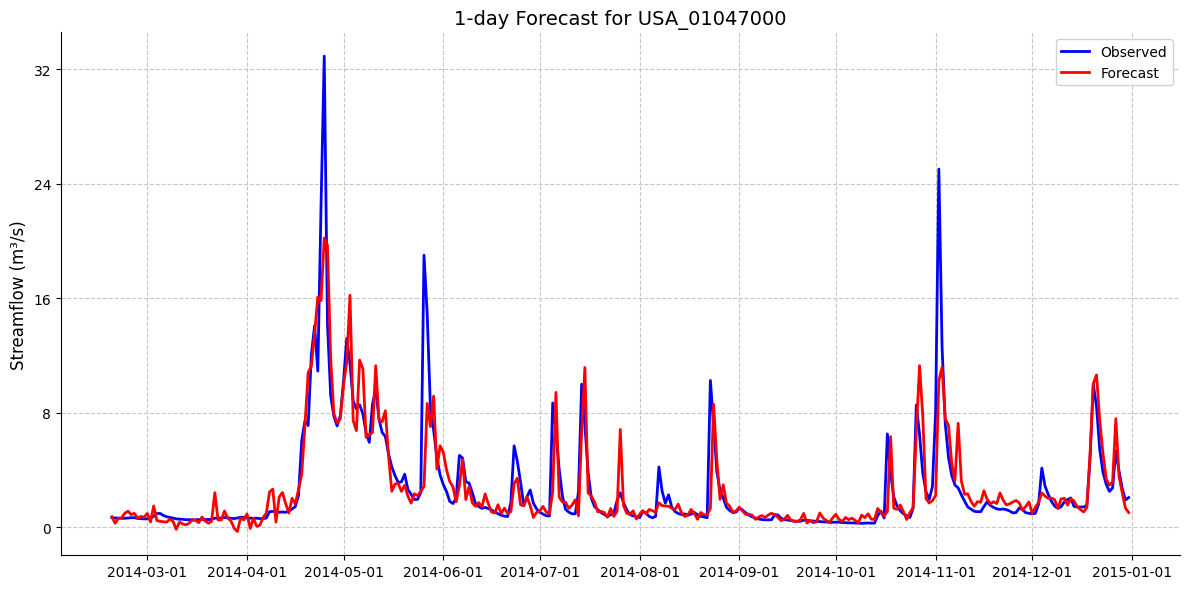

In [27]:
evaluator.test_results = raw_results

# Assuming you have an evaluator with test results already populated
fig, ax = evaluator.plot_rolling_forecast(
    horizon=1,
    group_identifier="USA_01047000",
    datamodule=data_module,
    y_label="Streamflow (m³/s)",
    debug=True,
    line_style_forecast="-",
)

plt.show()

In [28]:
overall_summary

,MSE,MAE,NSE,RMSE
horizon,,,,
1,4.133244,0.946400,0.725810,2.033038
2,6.977765,1.223147,0.536875,2.641546
3,7.722511,1.377183,0.487180,2.778941
4,8.244015,1.447871,0.454366,2.871239
5,8.698359,1.515454,0.426618,2.949298
6,8.463297,1.506968,0.442067,2.909175
7,8.678262,1.539559,0.427730,2.945889
8,8.849552,1.524812,0.416252,2.974820
9,9.006142,1.532901,0.405442,3.001024


In [29]:
basin_summary

MSE       MAE       NSE      RMSE
basin_id     horizon                                         
USA_01047000 1         4.155887  0.926793  0.717908  2.038599
             2         6.836859  1.189597  0.535533  2.614739
             3         7.908739  1.395336  0.462248  2.812248
             4         8.631854  1.476698  0.415767  2.938002
             5         9.194922  1.575202  0.379995  3.032313
             6         9.274120  1.580592  0.374712  3.045344
             7         9.408518  1.600475  0.365386  3.067331
             8         9.874594  1.598533  0.333679  3.142387
             9         9.703313  1.582821  0.344589  3.115014
             10       10.231090  1.622581  0.308273  3.198607
USA_01052500 1         4.110600  0.966006  0.732450  2.027462
             2         7.118671  1.256696  0.536540  2.668084
             3         7.536285  1.359030  0.509223  2.745229
             4         7.856173  1.419044  0.489418  2.802886
             5         8.201796  1.455706  0.469259  2.863878
             6         7.652473  1.433344  0.504646  2.766310
             7         7.948005  1.478644  0.485423  2.819221
             8         7.824510  1.451091  0.493292  2.797233
             9         8.308969  1.482981  0.461546  2.882528
             10        8.833426  1.475423  0.427277  2.972108

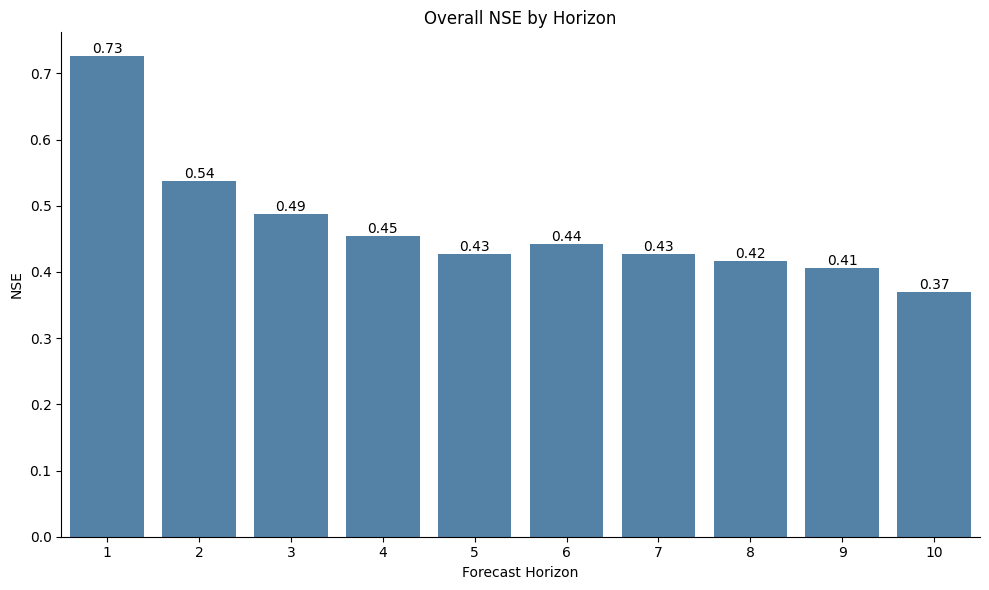

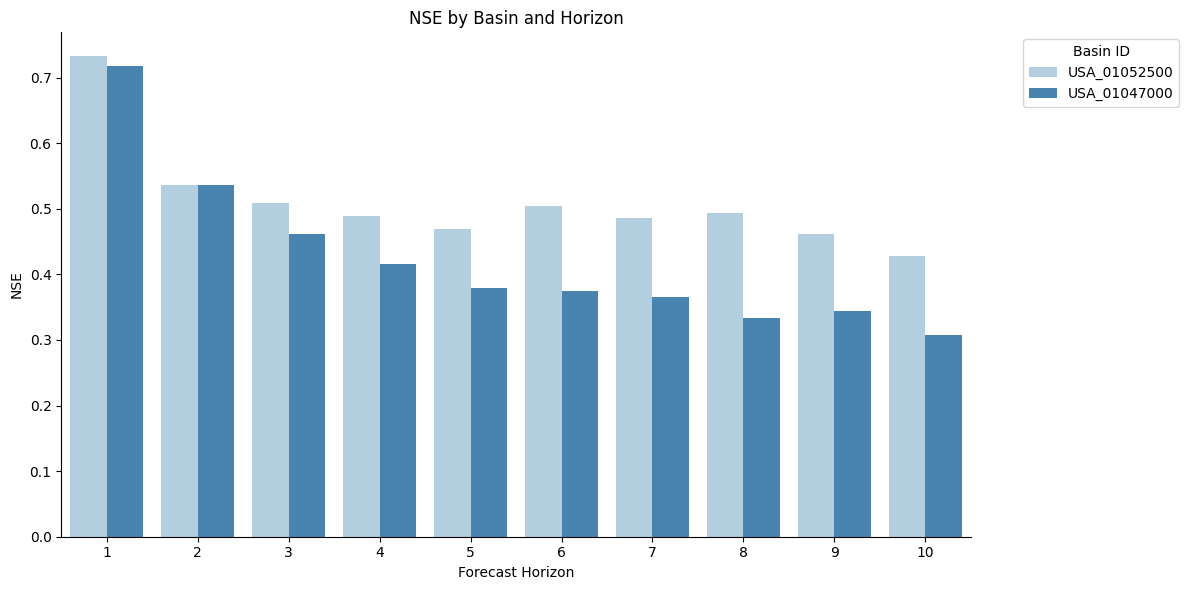

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(basin_summary, "NSE", per_basin=True, figsize=(12, 6))